In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# FGF In vitro Data - Her1::YFP Analysis
<a id='top'></a>

## Table of contents for this notebook

- [Data Import](#import): Upload the in vitro data to compare PSM4 vs PSM4 + FGF cells.

- [Plot all PSM4 cells](#psm4_plot): Plot all the PSM4 cells. These cells express Her1::YFP (Looping) and Mesp-b::mKate (Heidi).

- [Plot all PSM4 cells](#fgf_plot): Plot all the PSM4 cells treated with fgf8. These cells express Her1::YFP (Looping) and Mesp-b::mKate (Heidi).

- [Load and plot Peaks](#peaks): Here we load and show all the peaks detected in the notebook *FGF_ManualPeakSelector.ipynb*

- [Number of peaks Distribution](#peaks_dist): Distribution of the number of peaks for each condition (FGF and PSM4).

- [Periods and Amplitudes calculation](#pers_amps): Calculation of periods and amplitudes for each cell for each condition (PSM4 vs FGF).

- [Successive Period vs Successive Max Intensity Ratio](#succ_pers_amps): Once the periods and the max intensity is calculated, we then obtain the ratio of successive cycles to check whether the cells slow down and increase their intensity. 

- [Successive Period vs Successive Max intensity Ratio KDE](#kde): Same plot as before but using the Kernel Density Estimation (KDE).

- [I$^{+}$ vs I$^{-}$](#is): Is calculaed as specified later in the drawing.

- [Period calculation](#period): Period of each cell cycle by cycle.

### Upload the xlsx files

<a id='import'></a>
If you want to go to the top of the notebook click here: [Top](#top)

In [2]:
psm4 = [[2, 4, 7, 16, 24, 29, 31, 32, 33, 37, 48, 38, 40, 41, 45, 48, 49], 
       [38, 40, 41, 45, 48, 49],
       [50, 53, 55, 57, 58, 61, 64, 65, 67, 68, 71, 73],
       [2, 6, 7, 10, 24, 25, 27, 31, 33, 35, 36, 40, 43, 46, 48]]

psm4_fgf = [[53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 69, 70, 76, 79, 81, 82, 84, 98, 102, 104, 108], 
            [52, 54, 55, 59, 61],
            [87, 90, 91, 93, 95, 98, 101, 104, 105, 107, 108],
            [54, 55, 56, 60, 61, 62, 63, 67, 68, 69, 70, 71, 76, 79, 94, 97, 105]]

In [3]:
experiments = [436, 443, 444, 433]
exps_save = {'fgf': [], 'psm4': []} # save the experiment ID
exps_all = []
data_looping = [] # looping intensities
data_heidi = [] # heidi intensities
tod = [] # time of death
positions = []

label = [] # PSM4, FGF or none

for i, exp in enumerate(experiments):
    # Read the excel files - each sheet contains the looping or heidi intensities
    looping = pd.read_excel(f'../Data/FGF/wsc{exp}_mean_intensities_2022.xlsx', 
                            sheet_name = 'looping', header=[0])

    heidi = pd.read_excel(f'../Data/FGF/wsc{exp}_mean_intensities_2022.xlsx', 
                            sheet_name = 'heidi', header=[0])
    
    # Each experiment contains different cell positions
    positions.append(looping.keys().to_numpy()[1:])
    
    for pos in positions[i]:

        data_looping.append(looping[pos][1:].to_numpy())
        data_heidi.append(heidi[pos][1:].to_numpy())
        tod.append(looping[pos][0])
        if any(pos == np.array(psm4[i])):
            label.append('psm4')
            exps_all.append(exp)
            exps_save['psm4'].append(exp)
        elif any(pos == np.array(psm4_fgf[i])):
            label.append('fgf')
            exps_all.append(exp)
            exps_save['fgf'].append(exp)
        else:
            label.append('other')

n_cells = len(data_heidi)
looping.head() 

,position,2,6,7,10,24,25,27,31,33,...,67,68,69,70,71,76,79,94,97,105
0,TOD,67.000000,96.000000,78.000000,34.000000,62.000000,49.000000,48.000000,57.000000,56.000000,...,89.000000,87.000000,102.000000,121.000000,81.000000,49.000000,85.000000,60.000000,121.000000,121.000000
1,NaN,1124.608209,1113.306604,1157.834696,1113.533578,1144.284841,1134.995511,1109.366857,1151.278375,1136.839888,...,1105.369312,1223.439614,1132.674112,1112.731651,1156.412776,1159.939159,1126.243306,1123.891282,1133.910323,1163.630667
2,NaN,1184.880208,1170.239281,1186.582198,1152.308733,1171.918536,1248.068510,1136.544332,1200.523515,1149.974970,...,1102.378378,1258.888199,1145.122056,1106.761749,1202.491613,1203.380208,1137.211513,1201.383516,1127.926856,1187.427313
3,NaN,1176.413366,1200.920520,1241.033210,1358.415916,1167.230216,1466.799292,1171.849802,1239.163484,1167.107649,...,1129.124675,1240.583208,1158.689620,1111.563492,1199.661710,1163.808126,1129.246725,1211.403750,1124.945759,1170.970458
4,NaN,1172.209476,1166.420989,1268.540936,1451.276265,1172.391711,1603.680572,1141.747909,1272.262937,1139.220452,...,1138.324655,1207.305671,1159.585487,1111.191721,1163.326829,1193.938776,1141.762673,1210.366180,1138.900277,1240.509021


In [4]:
len(exps_all)

98

### Plot the results - PSM4 and PSM4 + FGF only

In [5]:
import warnings
warnings.filterwarnings("ignore")

#### PSM4 

<a id='psm4_plot'></a>

If you want to go to the top of the notebook click here: [Top](#top)

In [15]:
print(f'There are {label.count("psm4"):d} PSM4 cells')

There are 44 PSM4 cells


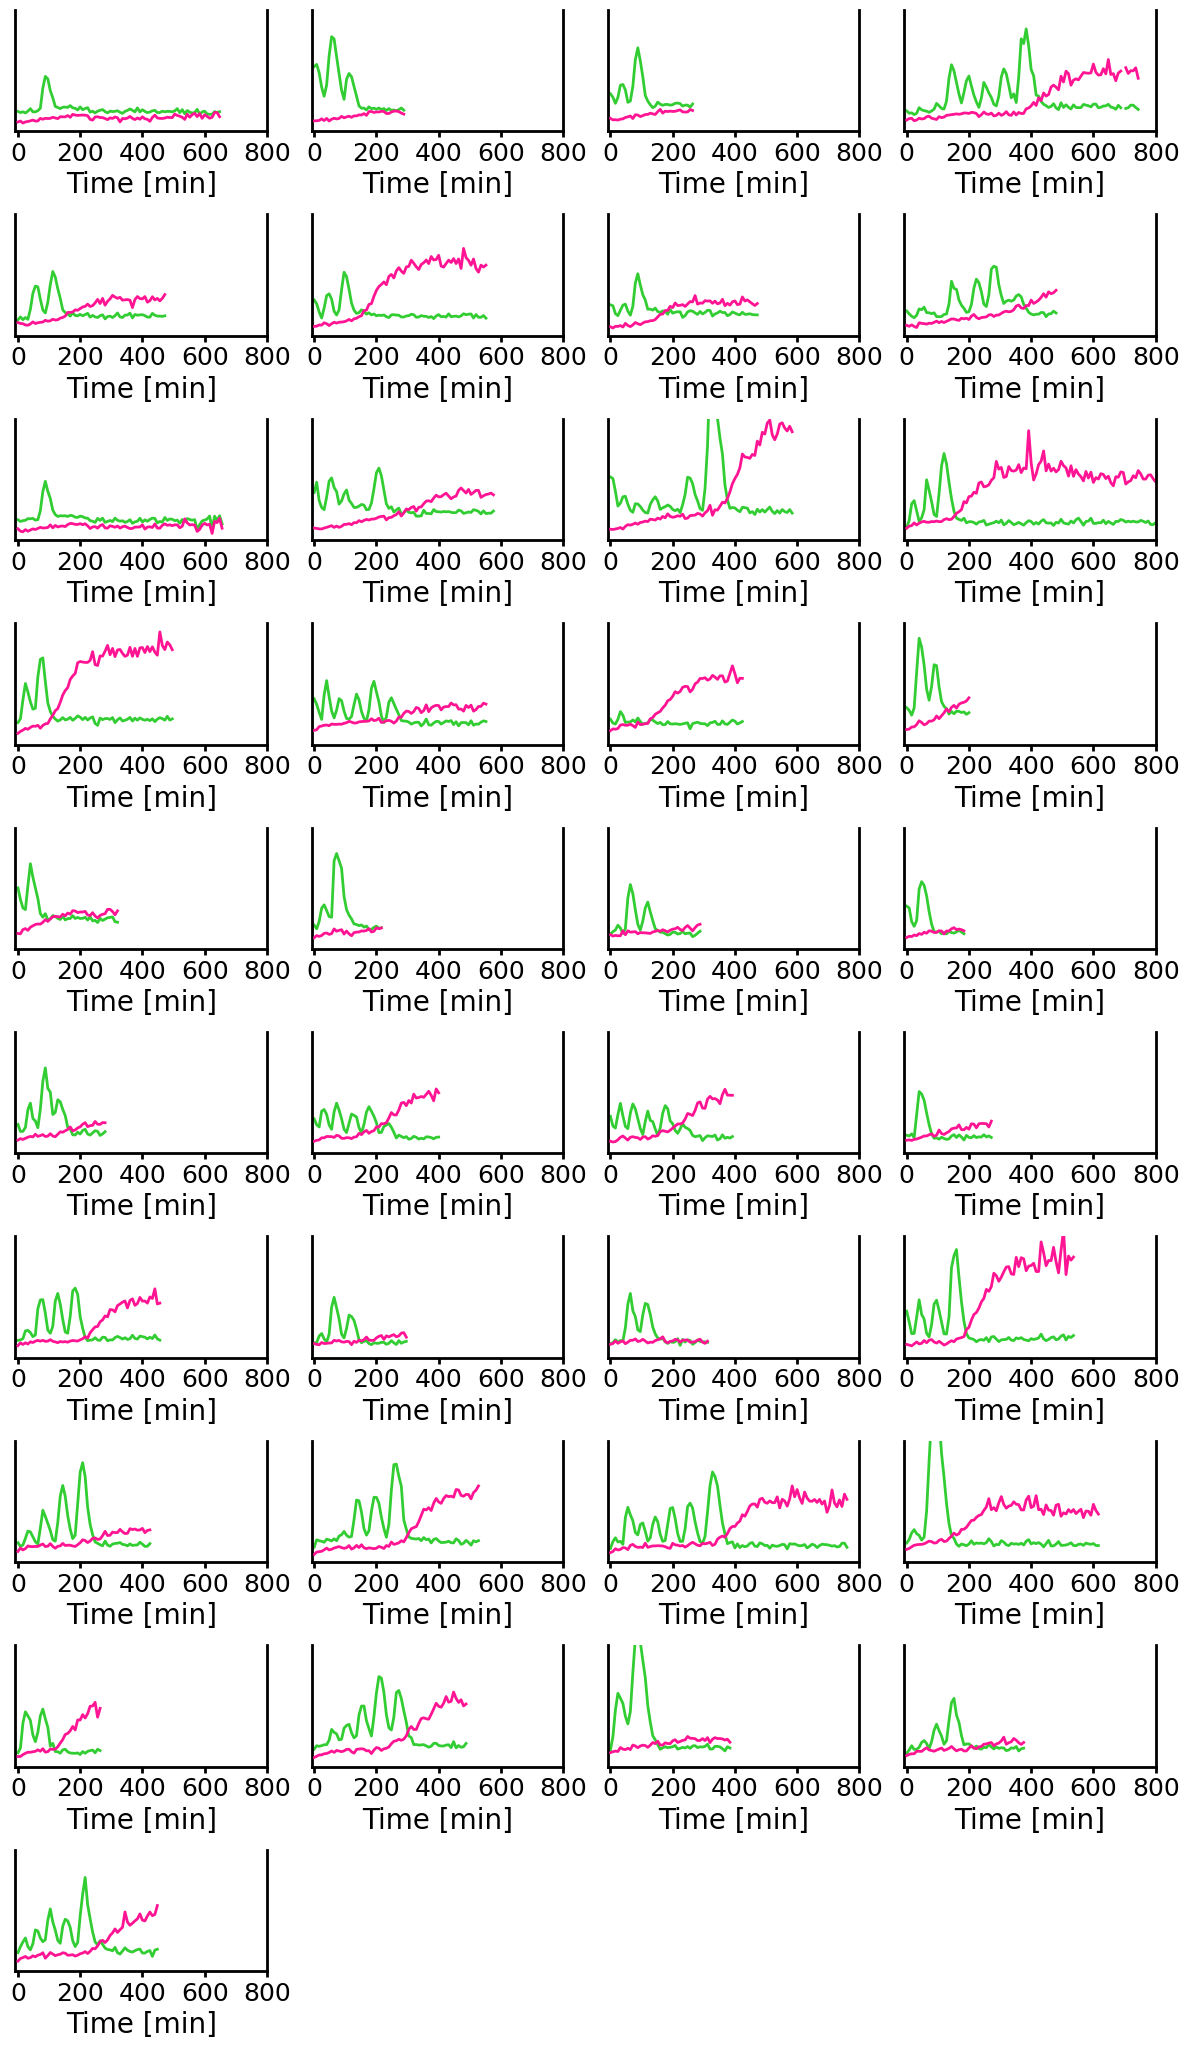

In [20]:
n_cols =  4
n_rows = np.ceil((label.count('psm4') + 1) / n_cols)
plot_num = 1

# Initialize the figure size
size_x = 3*n_cols
size_y = 2*n_rows

fig = plt.figure(figsize=[size_x,size_y])



tr = 10 # minutes
for i in range(n_cells):
    
    if label[i] == 'psm4':

        
        # Update the number of subplots    
        ax1 = plt.subplot(int(n_rows), n_cols, plot_num)
        plot_num += 1

        ax1.plot(np.arange(len(data_looping[i]))*tr, data_looping[i], 
                linewidth=2, color='limegreen')

        ax2=ax1.twinx()

        ax2.plot(np.arange(len(data_heidi[i]))*tr, data_heidi[i], 
                linewidth=2, color='deeppink')

        ax1.set_xlabel('Time [min]', fontsize=20)
        ax1.set_xticklabels(np.arange(0,1200,200), fontsize=18)
        ax1.set_xticks(np.arange(0,1500,250))
        ax1.set_xlim([-10,1000])
        ax1.set_ylim([1000, 2000])
        ax2.set_ylim([800,2000])
        ax1.tick_params(width=2, length=4)
        ax1.spines['top'].set_linewidth(0)
        ax2.spines['top'].set_linewidth(0)
        ax1.spines['bottom'].set_linewidth(2)
        ax1.spines['left'].set_linewidth(2)
        ax2.spines['right'].set_linewidth(2)

        ax1.set_yticklabels([])
        ax1.set_yticks([])

        ax2.set_yticklabels([])
        ax2.set_yticks([])
    
plt.tight_layout()
plt.show()

fig.savefig('../Data/FGF/Results/PSM4_LoopHeidi_fgf_vs_psm4.pdf', bbox_inches='tight')

#### PSM4 + FGF

<a id='fgf_plot'></a>

If you want to go to the top of the notebook click here: [Top](#top)

In [8]:
print(f'There are {label.count("fgf"):d} PSM4 + FGF cells')

There are 54 PSM4 + FGF cells


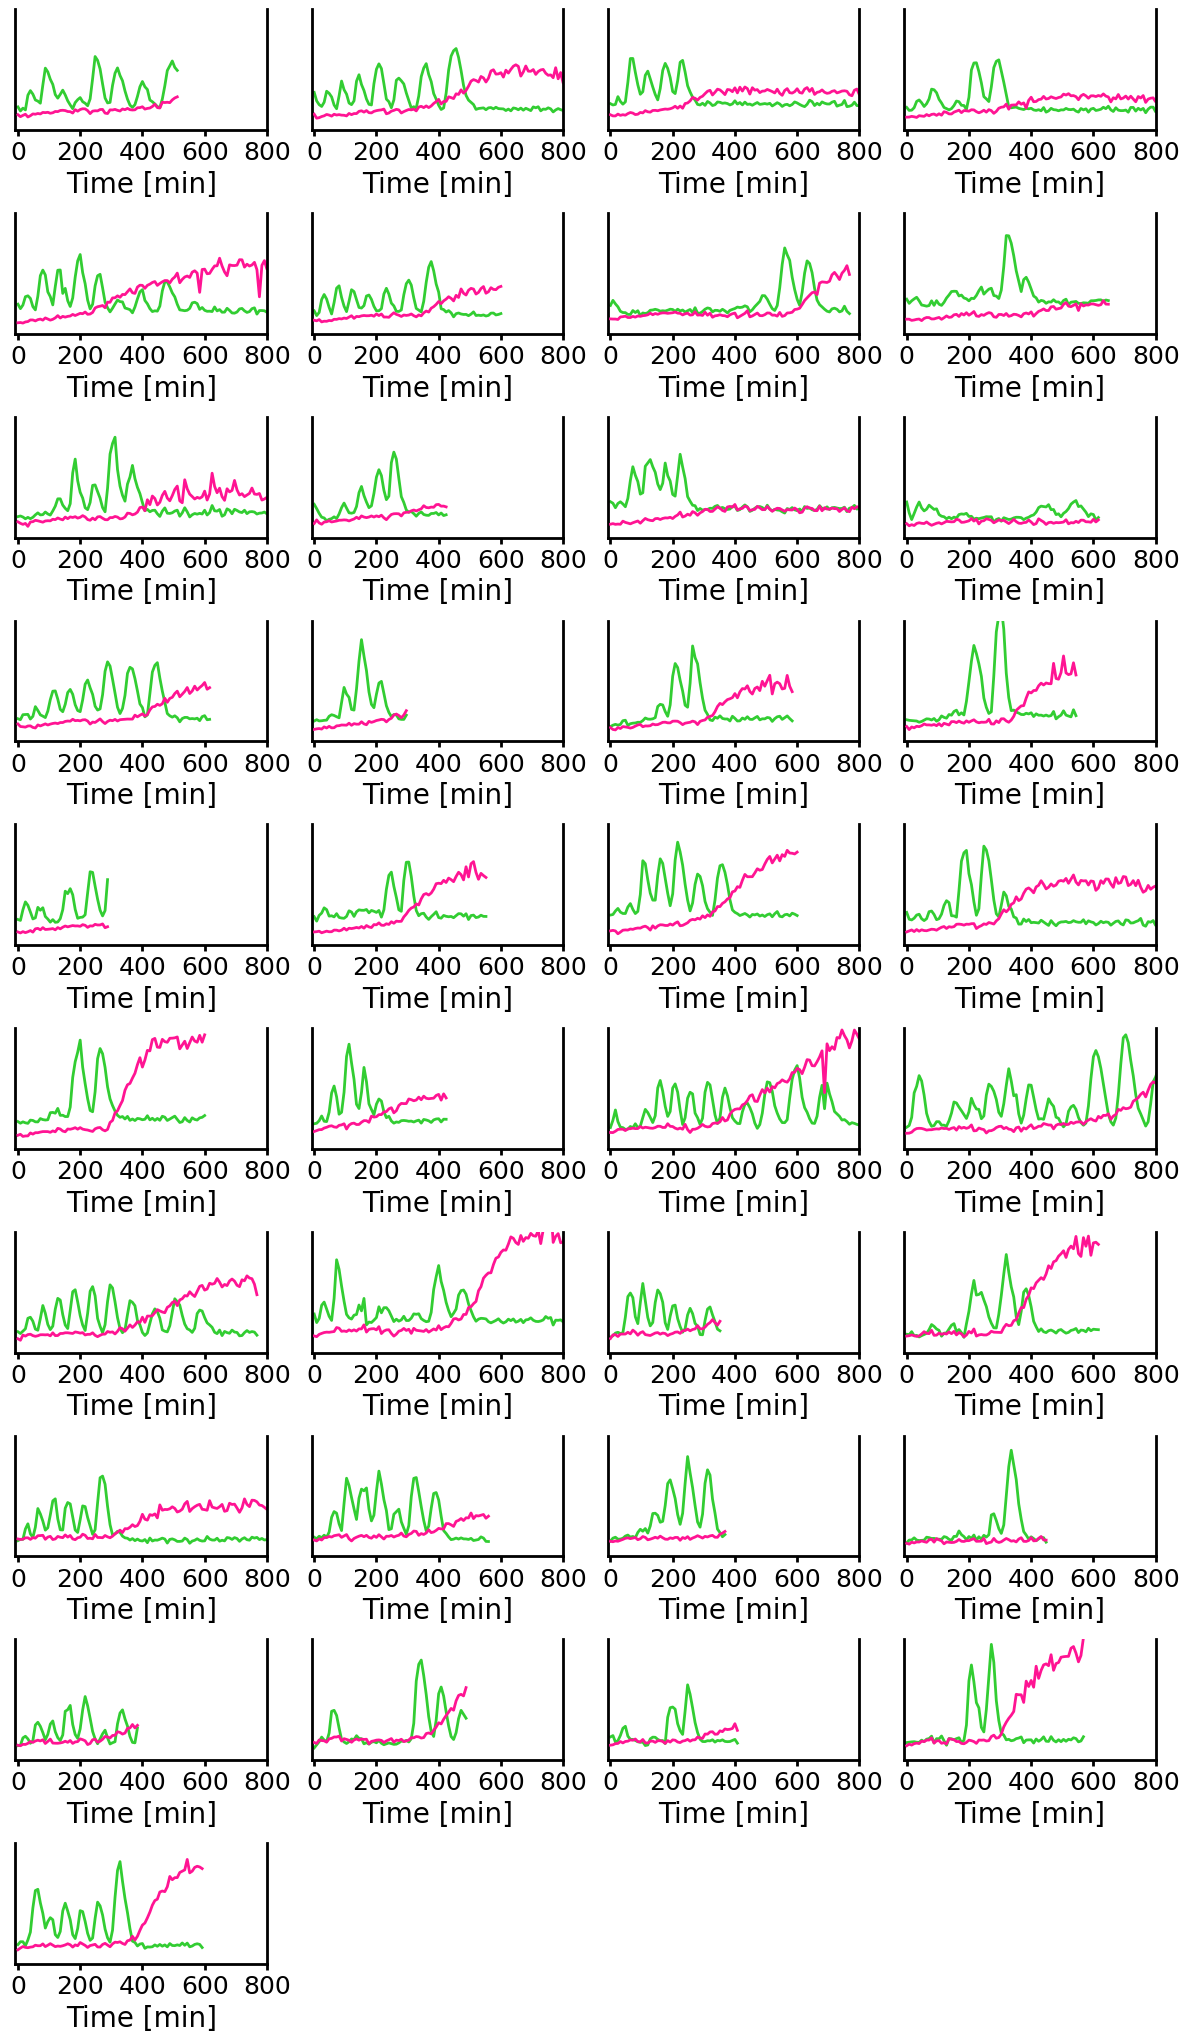

In [17]:
n_cols =  4
n_rows = np.ceil((label.count('fgf') + 1) / n_cols)
plot_num = 1

# Initialize the figure size
size_x = 3*n_cols
size_y = 2*n_rows

fig = plt.figure(figsize=[size_x,size_y])

tr = 10 # minutes
for i in range(n_cells):
    
    if label[i] == 'fgf':
        
        # Update the number of subplots    
        ax1 = plt.subplot(int(n_rows), n_cols, plot_num)
        plot_num += 1

        ax1.plot(np.arange(len(data_looping[i]))*tr, data_looping[i], 
                linewidth=2, color='limegreen')

        ax2=ax1.twinx()

        ax2.plot(np.arange(len(data_heidi[i]))*tr, data_heidi[i], 
                linewidth=2, color='deeppink')

        ax1.set_xlabel('Time [min]', fontsize=20)
        ax1.set_xticklabels(np.arange(0,1200,200), fontsize=18)
        ax1.set_xticks(np.arange(0,1500,250))
        ax1.set_xlim([-10,1000])
        ax1.set_ylim([1000, 2000])
        ax2.set_ylim([800,2000])
        ax1.tick_params(width=2, length=4)
        ax1.spines['top'].set_linewidth(0)
        ax2.spines['top'].set_linewidth(0)
        ax1.spines['bottom'].set_linewidth(2)
        ax1.spines['left'].set_linewidth(2)
        ax2.spines['right'].set_linewidth(2)

        ax1.set_yticklabels([])
        ax1.set_yticks([])

        ax2.set_yticklabels([])
        ax2.set_yticks([])
    
plt.tight_layout()
plt.show()

fig.savefig('../Data/FGF/Results/PSM4FGF_LoopHeidi_fgf_vs_psm4.pdf', bbox_inches='tight')

## Load peaks, intensities, indices
<a id='peaks'></a>

This data was obtained from the notebook FGF_ManualPeakSelector.


If you want to go to the top of the notebook click here: [Top](#top)

In [21]:
peak_time_max = np.load('../Data/FGF/peak_time_max.npy', allow_pickle=True)
max_val = np.load('../Data/FGF/max_val.npy', allow_pickle=True)
peak_time_min = np.load('../Data/FGF/peak_time_min.npy', allow_pickle=True)
min_val = np.load('../Data/FGF/min_val.npy', allow_pickle=True)
intensities = np.load('../Data/FGF/intensities.npy', allow_pickle=True)
labels = np.load('../Data/FGF/labels.npy', allow_pickle=True)
inds = np.load('../Data/FGF/inds.npy', allow_pickle=True)

### Plot minima and maxima peaks

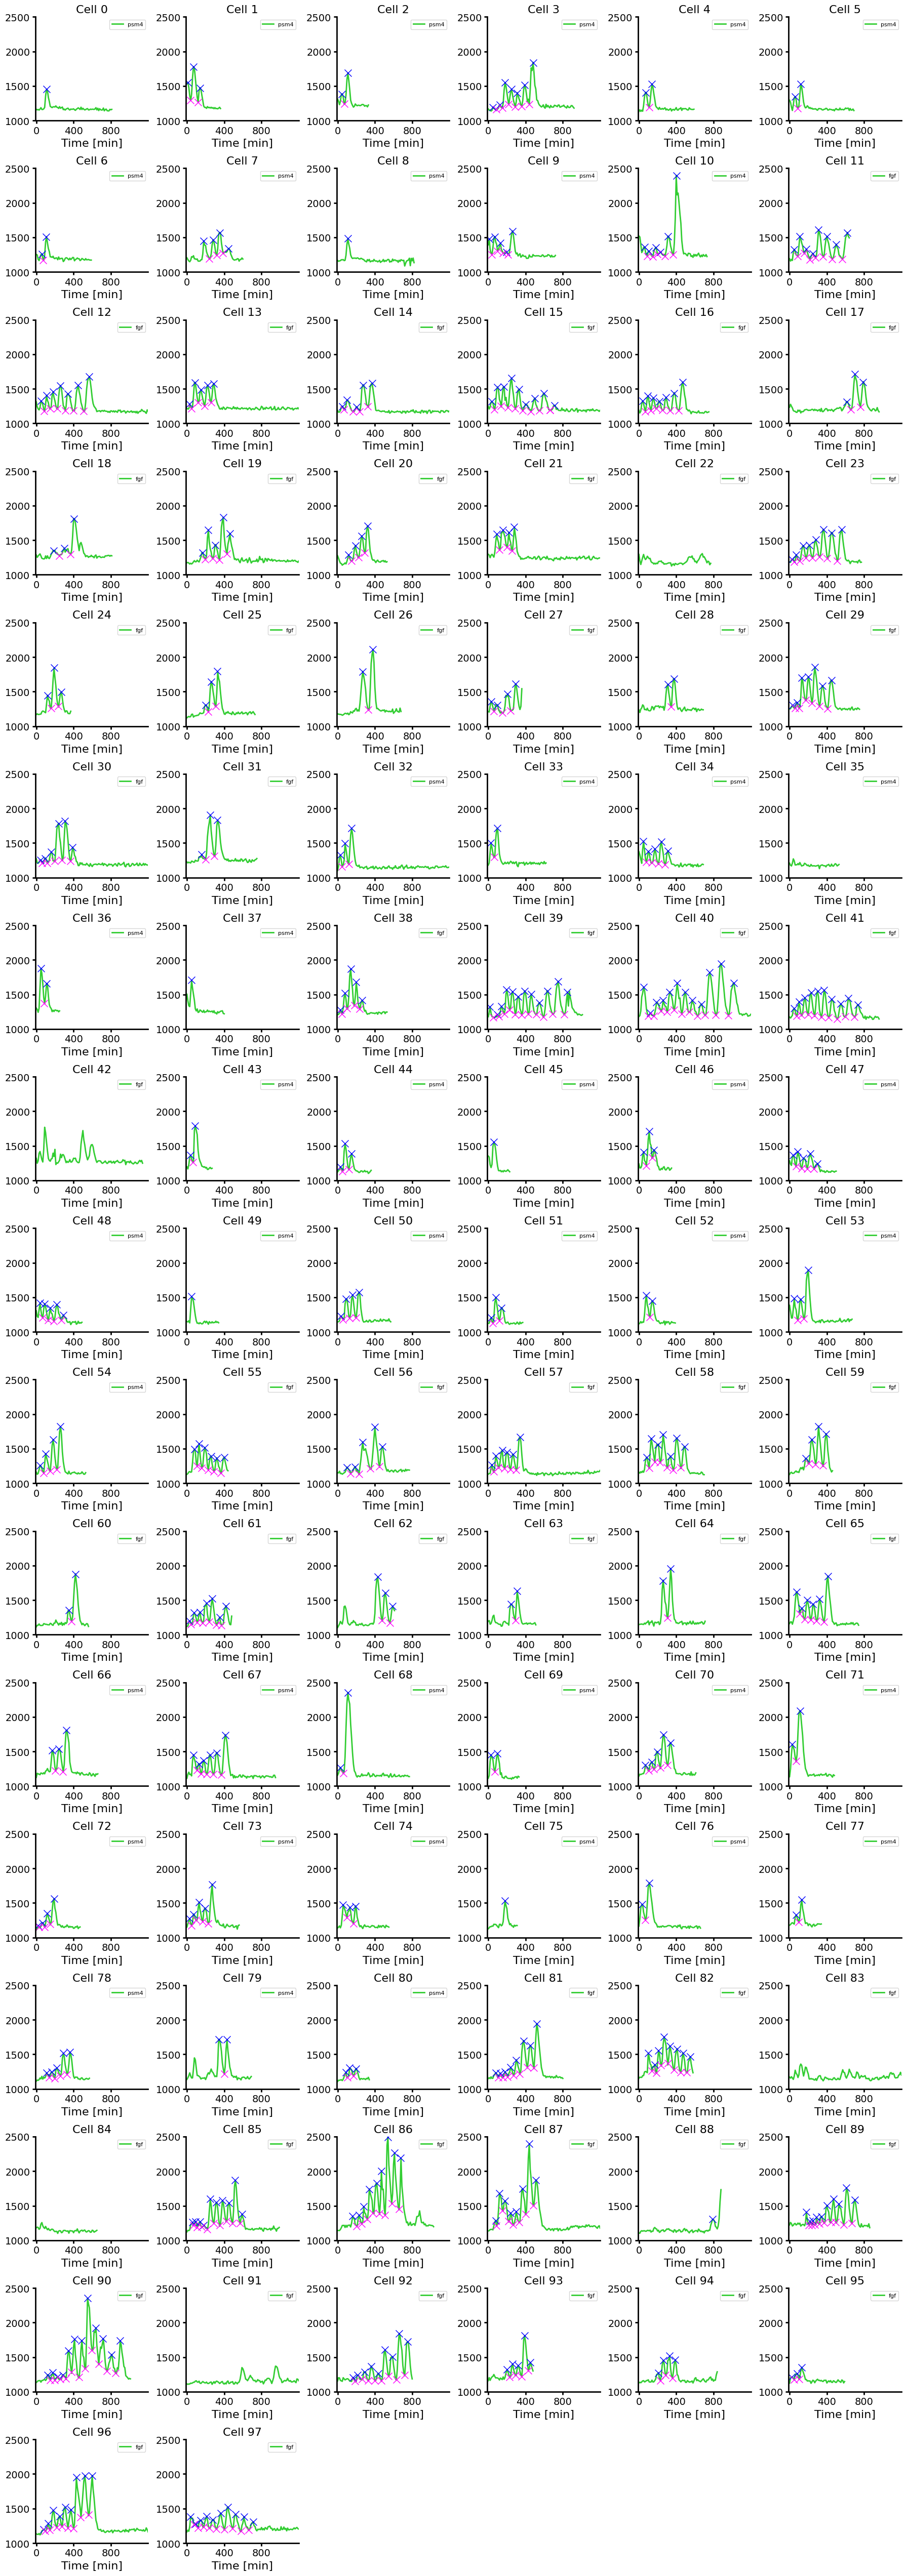

In [26]:
%matplotlib inline
tr = 10
n_cols =  6

n_cells = len(intensities)
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
size_x = 3*n_cols
size_y = 3*n_rows

fig = plt.figure(figsize=[size_x,size_y])


count = 0

n_peaks_fgf = []
n_peaks_psm4 = []

for i in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    if labels[i] == 'fgf':
        n_peaks_fgf.append(len(peak_time_max[i]))
    
    if labels[i] == 'psm4':
        n_peaks_psm4.append(len(peak_time_max[i]))
        
        
    plt.plot(np.arange(len(intensities[i]))*tr, intensities[i], linewidth=2, color='limegreen', label=labels[i])

    plt.plot(peak_time_max[i], max_val[i], "x", color='blue', markersize=10); 
    plt.plot(peak_time_min[i], min_val[i], "x", color='magenta', markersize=10); 

    plt.title('Cell %d'%i, fontsize=16)
    plt.ylim([1000,2500])
    plt.legend(loc='best', fontsize=8)

    plt.xlabel('Time [min]', fontsize=16)
    plt.xticks(np.arange(0, 1200, 400), fontsize=14)
    plt.yticks(np.arange(1000, 2750, 500), fontsize=14)
    #plt.set_xticks(np.arange(0,150,25))
    plt.xlim([-10,1200])

    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)
    
plt.tight_layout()
plt.show()   

### Number of peak distribution
<a id='peaks_dist'></a>

If you want to go to the top of the notebook click here: [Top](#top)

In [27]:
print(f'There are {len(n_peaks_psm4)} PSM4 cells')

There are 44 PSM4 cells


In [28]:
print(f'There are {len(n_peaks_fgf)} PSM4 + FGF cells')

There are 54 PSM4 + FGF cells


In [29]:
n_peaks = [n_peaks_psm4, n_peaks_fgf]
percentage_all = []

for j in range(2):
    unique_peaks = np.unique(n_peaks[j])
    percentage = np.zeros(np.max(unique_peaks)+1)

    for i,val in enumerate(unique_peaks):
        percentage[val] = len(np.where(np.array(n_peaks[j]) == val)[0])
    
    percentage_all.append(percentage)

In [30]:
percent_cells_psm4 = pd.DataFrame({'Total': percentage_all[0]})
percent_cells_fgf = pd.DataFrame({'Total': percentage_all[1]})

### Check Distribution for each experiment

#### PSM4

In [31]:
psm4_433 = []
psm4_436 = []
psm4_443 = []
psm4_444 = []

inds = np.where(labels=='psm4')[0]

for i, val in enumerate(inds):
    
    if exps_all[val]==433:
        psm4_433.append(n_peaks_psm4[i])
    elif exps_all[val]==436:
        psm4_436.append(n_peaks_psm4[i])
    elif exps_all[val]==443:
        psm4_443.append(n_peaks_psm4[i])
    elif exps_all[val]==444:
        psm4_444.append(n_peaks_psm4[i])

In [32]:
pd.DataFrame({'PSM4_433': psm4_433}).to_csv('../Data/FGF/FGF_Data_Simulation/PSM4_433.csv')
pd.DataFrame({'PSM4_436': psm4_436}).to_csv('../Data/FGF/FGF_Data_Simulation/PSM4_436.csv')
pd.DataFrame({'PSM4_443': psm4_443}).to_csv('../Data/FGF/FGF_Data_Simulation/PSM4_443.csv')
pd.DataFrame({'PSM4_444': psm4_444}).to_csv('../Data/FGF/FGF_Data_Simulation/PSM4_444.csv')

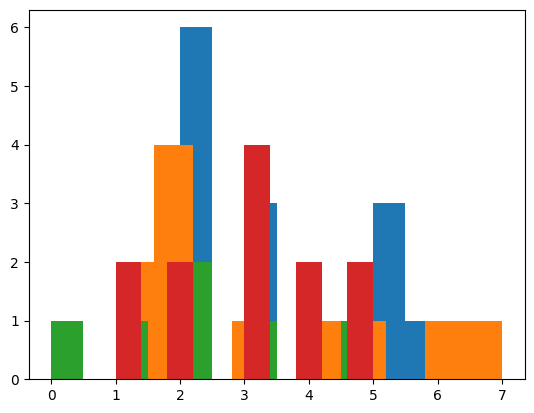

In [33]:
plt.hist(psm4_433);
plt.hist(psm4_436);
plt.hist(psm4_443);
plt.hist(psm4_444);

In [34]:
len(psm4_433)+len(psm4_436)+len(psm4_443)+len(psm4_444)

44

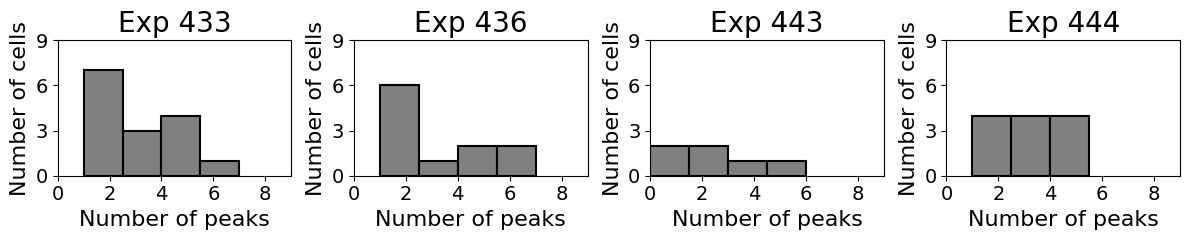

In [35]:
data = [psm4_433, psm4_436, psm4_443, psm4_444]

n_cols =  4
n_rows = np.ceil((4 + 1) / n_cols)
plot_num = 1

size_fig = 1*(10/n_cols)

fig = plt.figure(figsize=[12, size_fig])
exps_id = [433, 436, 443, 444]
binwidth = 1.5

cov_peak_nums = []
all_peaks_nums = []
for i, val in enumerate(data):
    plt.subplot(1,4, i+1)
    plt.hist(val, color='grey', edgecolor='black', linewidth=1.5,
            bins=np.arange(min(val), max(val) + binwidth, binwidth))
    
    cov_peak_nums.append(np.std(val)/np.mean(val))
    all_peaks_nums+= val
    
    plt.xticks(np.arange(0,9,2), fontsize=14)
    plt.xlim([0,9])
    plt.yticks(np.arange(0,15,3), fontsize=14)
    plt.ylim([0,9])
    plt.title('Exp %d'%exps_id[i], fontsize=20)
    plt.xlabel('Number of peaks', fontsize=16)
    plt.ylabel('Number of cells', fontsize=16)
    
plt.tight_layout()

fig.savefig('../Data/FGF/Results/variability_exps_PSM4.pdf', bbox_inches='tight')

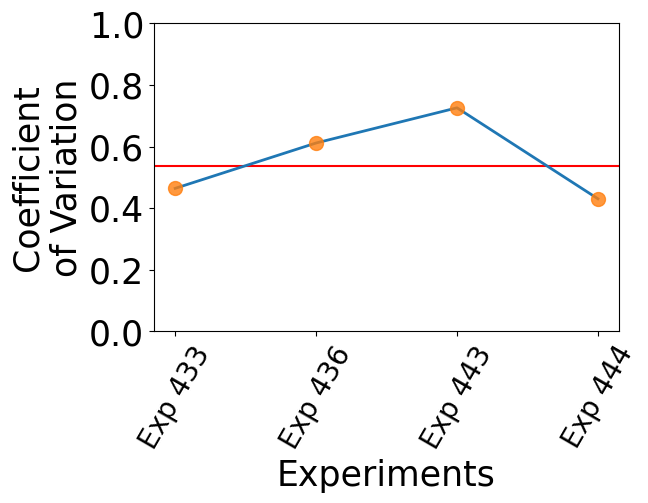

In [36]:
# Coefficient of variation
fig = plt.figure(figsize=[6,4])
labels = []
for i in range(4):
    labels.append('Exp %d'%exps_id[i])

plt.axhline(np.std(all_peaks_nums)/np.mean(all_peaks_nums), color='red')
plt.plot(cov_peak_nums, linewidth=2)
plt.plot(cov_peak_nums, 'o', markersize=10, alpha=0.8)
plt.ylim([0,1])
plt.xlabel('Experiments', fontsize=25)
plt.xticks(np.arange(0,4,1), labels, fontsize=20, rotation=60)
plt.yticks(fontsize=25);
plt.ylabel('Coefficient\nof Variation', fontsize=25)

fig.savefig('../Data/FGF/Results/COV_psm4.pdf', bbox_inches='tight')

#### PSM4 + FGF

In [37]:
labels = np.load('../Data/FGF/labels.npy', allow_pickle=True)

In [38]:
fgf_433 = []
fgf_436 = []
fgf_443 = []
fgf_444 = []

inds = np.where(labels=='fgf')[0]

for i, val in enumerate(inds):
    
    if exps_all[val]==433:
        fgf_433.append(n_peaks_fgf[i])
    elif exps_all[val]==436:
        fgf_436.append(n_peaks_fgf[i])
    elif exps_all[val]==443:
        fgf_443.append(n_peaks_fgf[i])
    elif exps_all[val]==444:
        fgf_444.append(n_peaks_fgf[i])

In [39]:
pd.DataFrame({'fgf_433': fgf_433}).to_csv('../Data/FGF/FGF_Data_Simulation/fgf_433.csv')
pd.DataFrame({'fgf_436': fgf_436}).to_csv('../Data/FGF/FGF_Data_Simulation/fgf_436.csv')
pd.DataFrame({'fgf_443': fgf_443}).to_csv('../Data/FGF/FGF_Data_Simulation/fgf_443.csv')
pd.DataFrame({'fgf_444': fgf_444}).to_csv('../Data/FGF/FGF_Data_Simulation/fgf_444.csv')

In [40]:
len(fgf_433)+len(fgf_436)+len(fgf_443)+len(fgf_444)

54

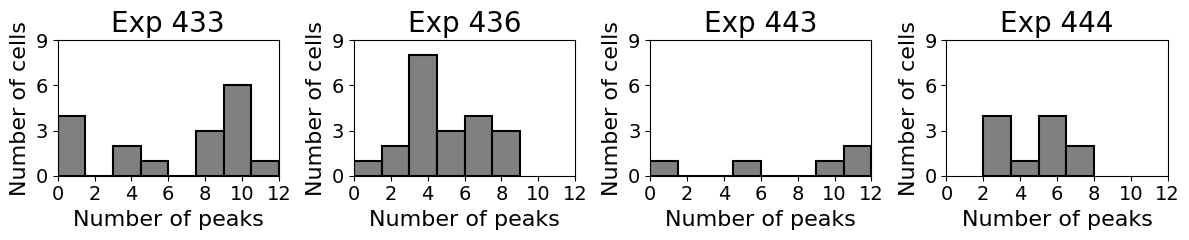

In [41]:
data = [fgf_433, fgf_436, fgf_443, fgf_444]

n_cols =  4
n_rows = np.ceil((4 + 1) / n_cols)
plot_num = 1

size_fig = 1*(10/n_cols)

fig = plt.figure(figsize=[12, size_fig])
exps_id = [433, 436, 443, 444]
binwidth = 1.5

cov_peak_nums = []
all_peaks_nums = []
for i, val in enumerate(data):
    plt.subplot(1,4, i+1)
    plt.hist(val, color='grey', edgecolor='black', linewidth=1.5,
            bins=np.arange(min(val), max(val) + binwidth, binwidth))
    
    cov_peak_nums.append(np.std(val)/np.mean(val))
    all_peaks_nums+= val
    
    plt.xticks(np.arange(0,14,2), fontsize=14)
    plt.xlim([0,12])
    plt.yticks(np.arange(0,15,3), fontsize=14)
    plt.ylim([0,9])
    plt.title('Exp %d'%exps_id[i], fontsize=20)
    plt.xlabel('Number of peaks', fontsize=16)
    plt.ylabel('Number of cells', fontsize=16)
    
plt.tight_layout()

fig.savefig('../Data/FGF/Results/variability_exps_fgf.pdf', bbox_inches='tight')

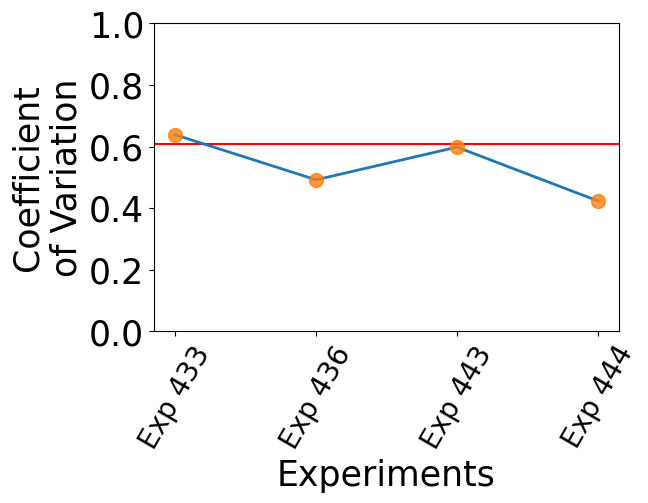

In [42]:
# Coefficient of variation
fig = plt.figure(figsize=[6,4])
labels = []
for i in range(4):
    labels.append('Exp %d'%exps_id[i])

plt.axhline(np.std(all_peaks_nums)/np.mean(all_peaks_nums), color='red')
plt.plot(cov_peak_nums, linewidth=2)
plt.plot(cov_peak_nums, 'o', markersize=10, alpha=0.8)
plt.ylim([0,1])
plt.xlabel('Experiments', fontsize=25)
plt.xticks(np.arange(0,4,1), labels, fontsize=20, rotation=60)
plt.yticks(fontsize=25);
plt.ylabel('Coefficient\nof Variation', fontsize=25)

fig.savefig('../Data/FGF/Results/COV_fgf.pdf', bbox_inches='tight')

#### PSM4 Cells

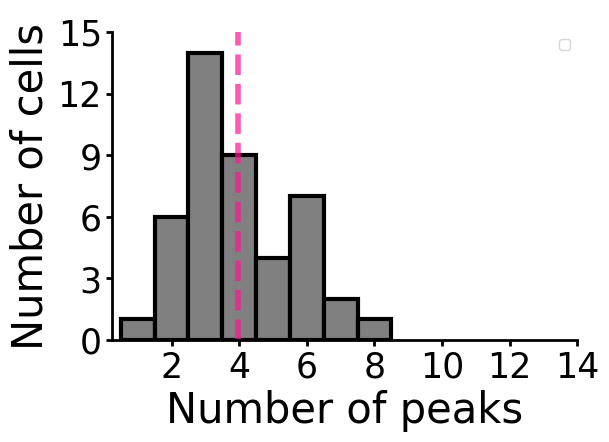

Mean: 3.97727
Standard Deviation: 1.78968


In [43]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[6,4])

percent_cells_psm4.plot.bar(rot=0, subplots=True, color='grey', edgecolor='black', 
                           linewidth=3, width=1, ax=ax, alpha=1)

plt.axvline(np.mean(n_peaks_psm4), linewidth=4, color='deeppink', alpha=0.7, 
           linestyle='dashed')

plt.xticks(np.arange(1,15,2), np.arange(2,16,2), fontsize=25)
plt.yticks(np.arange(0, 18, 3), fontsize=25)
plt.legend([])
plt.xlabel('Number of peaks', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.ylim([0, 15])
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.title(' ')
plt.show()

fig.savefig('../Data/FGF/Results/PeakHistogram-PSM4.pdf', format='pdf', bbox_inches='tight')

print('Mean: %g'%np.average(np.arange(1,len(percent_cells_psm4['Total'])+1,1), weights=percent_cells_psm4['Total']))
print('Standard Deviation: %g'%np.sqrt(np.cov(np.arange(1,len(percent_cells_psm4['Total'])+1,1), aweights=percent_cells_psm4['Total'])))

In [44]:
# Save the data for Simularion
percent_cells_psm4.to_csv('../Data/FGF/FGF_Data_Simulation/PSM4_periods.csv')

#### PSM4 + FGF Cells

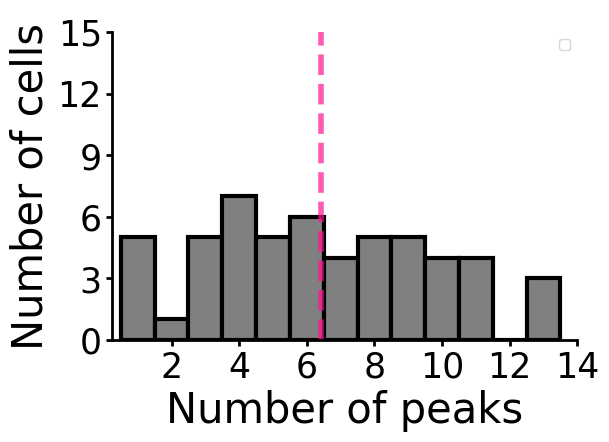

Mean: 6.42593
Standard Deviation: 3.46634


In [45]:
fig, ax = plt.subplots(figsize=[6,4])

percent_cells_fgf.plot.bar(rot=0, subplots=True, color='grey', edgecolor='black', 
                           linewidth=3, width=1, ax=ax, alpha=1)

plt.axvline(np.mean(n_peaks_fgf), linewidth=4, color='deeppink', alpha=0.7, 
           linestyle='dashed')

plt.xticks(np.arange(1,15,2), np.arange(2,16,2), fontsize=25)
plt.yticks(np.arange(0, 18, 3), fontsize=25)
plt.legend([])
plt.xlabel('Number of peaks', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.ylim([0, 15])
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.title(' ')
plt.show()

fig.savefig('../Data/FGF/Results/PeakHistogram-PSM4-FGF.pdf', format='pdf', bbox_inches='tight')

print('Mean: %g'%np.average(np.arange(1,len(percent_cells_fgf['Total'])+1,1), weights=percent_cells_fgf['Total']))
print('Standard Deviation: %g'%np.sqrt(np.cov(np.arange(1,len(percent_cells_fgf['Total'])+1,1), aweights=percent_cells_fgf['Total'])))

In [46]:
# Save the data for Simularion
percent_cells_fgf.to_csv('../Data/FGF/FGF_Data_Simulation/FGF_periods.csv')

## Period and Amplitude analysis

<a id='pers_amps'></a>
If you want to go to the top of the notebook click here: [Top](#top)

In [48]:
n_cells = len(intensities)

periods = []

i_plus = []
i_minus = []

for i in range(n_cells):
    periods.append(np.diff(peak_time_max[i]))
    
    i_minus_aux = []
    i_plus_aux = []
    
    for j in range(len(peak_time_max[i])-1):
        
        i_plus_aux.append(max_val[i][j])
        i_minus_aux.append(min_val[i][j])
    
    
    i_minus.append(i_minus_aux)
    i_plus.append(i_plus_aux)

### Successive period and amplitude ratio
<a id='succ_pers_amps'></a>
If you want to go to the top of the notebook click here: [Top](#top)

In [49]:
labels = np.load('../Data/FGF/labels.npy', allow_pickle=True)

In [50]:
period_ratio = []
amplitude_ratio = []
label_ratio = []

for i in range(n_cells):
    if len(periods[i])>1:
        period_ratio.append( [periods[i][1+j]/periods[i][j] for j in range(len(periods[i])-1)] )
        amplitude_ratio.append( [amplitudes[i][1+j]/amplitudes[i][j] for j in range(len(amplitudes[i])-1)] )
        label_ratio.append(labels[i])

#### Successive period-amplitude in PSM4

23


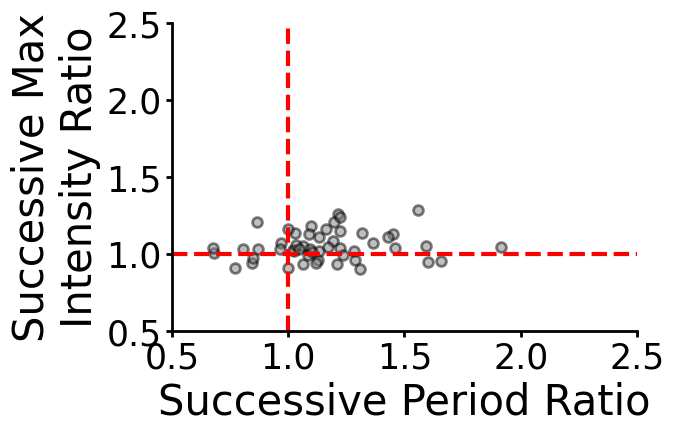

In [51]:
fig = plt.figure(figsize=[6,4])
n_cells = len(period_ratio)

count = 0
# How many cycles have a ratio over 1
ratio_1 = 0
ratio_2 = 0
ratio_3 = 0
ratio_4 = 0
# Total number of cycles
ratio_total = 0
for i in range(n_cells):
    if label_ratio[i] == 'psm4':
        plt.scatter(period_ratio[i], amplitude_ratio[i], color='gray', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        count += 1
        # upper right
        ratio_1 += len(np.where((np.array(period_ratio[i])>=1) & (np.array(amplitude_ratio[i])>=1))[0])
        # upper left
        ratio_2 += len(np.where((np.array(period_ratio[i])<1) & (np.array(amplitude_ratio[i])>=1))[0])
        # lower left
        ratio_3 += len(np.where((np.array(period_ratio[i])<1) & (np.array(amplitude_ratio[i])<1))[0])
        # lower right
        ratio_4 += len(np.where((np.array(period_ratio[i])>=1) & (np.array(amplitude_ratio[i])<1))[0])
        
        ratio_total += len(np.array(period_ratio[i]))
        
print(count)
plt.axvline(1, linewidth=3, linestyle='dashed', color='red')
plt.axhline(1, linewidth=3, linestyle='dashed', color='red')

plt.xlim([0.5,2.5])
plt.ylim([0.5,2.5])
plt.xticks(np.arange(0.5,3, 0.5), fontsize=25)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=25)

plt.xlabel('Successive Period Ratio', fontsize=30)
plt.ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/SuccessivePeriod-Amplitude.pdf', format='pdf', bbox_inches='tight')

In [56]:
# UPPER RIGHT
persent_ratio_1 = ratio_1*100/ratio_total
print(f'UPPER RIGHT: {persent_ratio_1:.1f} % cycles')

# UPPER LEFT
persent_ratio_2 = ratio_2*100/ratio_total
print(f'UPPER LEFT: {persent_ratio_2:.1f} % cycles')

# LOWER LEFT
persent_ratio_3 = ratio_3*100/ratio_total
print(f'LOWER LEFT: {persent_ratio_3:.1f} % cycles')

# LOWER RIGHT
persent_ratio_4 = ratio_4*100/ratio_total
print(f'LOWER RIGHT: {persent_ratio_4:.1f} % cycles')

UPPER RIGHT: 58.8 % cycles
UPPER LEFT: 13.7 % cycles
LOWER LEFT: 5.9 % cycles
LOWER RIGHT: 21.6 % cycles


In [57]:
print('Total number of cycles: ', ratio_total)

Total number of cycles:  51


### Successive Max intensity vs Perio Ratio - KDE

<a id='kde'></a>
If you want to go to the top of the notebook click here: [Top](#top)

Kernel Density Estimation for the same figure as above but instead of plotting each individual cell, we have a Density plot. 

#### Same plot as before but with the cells as scatter plot inside

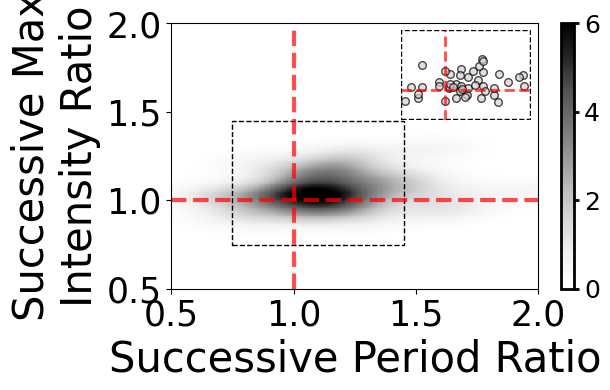

In [58]:
fig = plt.figure(figsize=[6.5, 4])
ax = fig.add_subplot(111)
# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location

mesh = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), 
               shading='auto', cmap='Greys', vmin=0, vmax=6)

axins = inset_axes(ax, width=1.3, height=0.9)

for i in range(n_cells):
    if label_ratio[i] == 'psm4':
        axins.scatter(period_ratio[i], amplitude_ratio[i], color='lightgrey', s=30, linewidth=1, edgecolor='black', alpha=0.7)
        count += 1
        
axins.axis('off')
axins.set_xlim([0.75, 1.5])
axins.set_ylim([0.75, 1.5])
        
# Colorbar
cb = plt.colorbar(mesh, ax=ax)
cb.outline.set_linewidth(2)
cb.set_ticks(np.arange(0,7,2))
cb.set_ticklabels(np.arange(0,7,2), fontsize=18)
cb.ax.tick_params(width=2)

x_rect = 0.75
y_rect = 0.75
width = 0.70
height = 0.70
ax.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

x_rect = 0.75
y_rect = 0.76
width = 0.745
height = 0.74
axins.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

# Axes
ax.axvline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)
ax.axhline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)

axins.axvline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)
axins.axhline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)

ax.set(xlim=(xy_min,xy_max), ylim=(xy_min,xy_max))
ax.set_xticks(np.arange(xy_min,xy_max+step, step))
ax.set_yticks(np.arange(xy_min,xy_max+step, step))
ax.set_xticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)
ax.set_yticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)

ax.set_xlabel('Successive Period Ratio', fontsize=30)
ax.set_ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()



fig.savefig('../Data/FGF/Results/SuccessivePeak-Intensity_PSM4_psm4_vs_fgf.pdf', bbox_inches='tight')

#### Successive period-amplitude in PSM4 + FGF

43


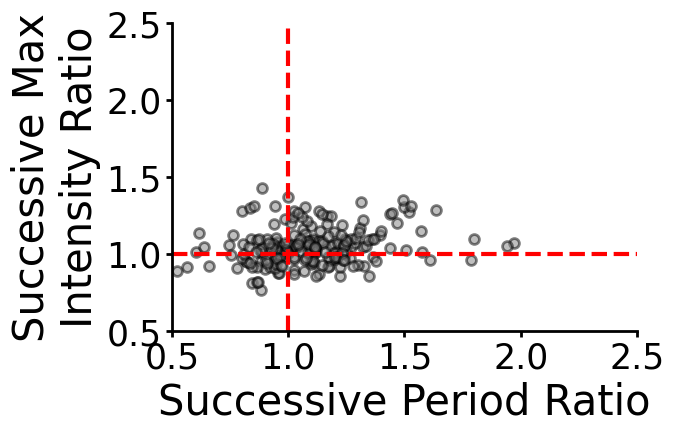

In [59]:
fig = plt.figure(figsize=[6,4])
n_cells = len(period_ratio)

count = 0
ratio_1 = 0
ratio_2 = 0
ratio_3 = 0
ratio_4 = 0
ratio_total = 0

for i in range(n_cells):
    if label_ratio[i] == 'fgf':
        plt.scatter(period_ratio[i], amplitude_ratio[i], color='gray', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        count += 1
        # upper right
        ratio_1 += len(np.where((np.array(period_ratio[i])>=1) & (np.array(amplitude_ratio[i])>=1))[0])
        # upper left
        ratio_2 += len(np.where((np.array(period_ratio[i])<1) & (np.array(amplitude_ratio[i])>=1))[0])
        # lower left
        ratio_3 += len(np.where((np.array(period_ratio[i])<1) & (np.array(amplitude_ratio[i])<1))[0])
        # lower right
        ratio_4 += len(np.where((np.array(period_ratio[i])>=1) & (np.array(amplitude_ratio[i])<1))[0])
        ratio_total += len(np.array(period_ratio[i]))
print(count)

plt.axvline(1, linewidth=3, linestyle='dashed', color='red')
plt.axhline(1, linewidth=3, linestyle='dashed', color='red')

plt.xlim([0.5,2.5])
plt.ylim([0.5,2.5])
plt.xticks(np.arange(0.5,3, 0.5), fontsize=25)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=25)

plt.xlabel('Successive Period Ratio', fontsize=30)
plt.ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/SuccessivePeriod-Amplitude.pdf', format='pdf', bbox_inches='tight')




In [60]:
# UPPER RIGHT
persent_ratio_1 = ratio_1*100/ratio_total
print(f'UPPER RIGHT: {persent_ratio_1:.1f} % cycles')

# UPPER LEFT
persent_ratio_2 = ratio_2*100/ratio_total
print(f'UPPER LEFT: {persent_ratio_2:.1f} % cycles')

# LOWER LEFT
persent_ratio_3 = ratio_3*100/ratio_total
print(f'LOWER LEFT: {persent_ratio_3:.1f} % cycles')

# LOWER RIGHT
persent_ratio_4 = ratio_4*100/ratio_total
print(f'LOWER RIGHT: {persent_ratio_4:.1f} % cycles')

UPPER RIGHT: 46.9 % cycles
UPPER LEFT: 18.9 % cycles
LOWER LEFT: 16.3 % cycles
LOWER RIGHT: 17.9 % cycles


In [61]:
print('Total number of cycles: ', ratio_total)

Total number of cycles:  196


#### Same plot as before but with the cells as scatter plot inside

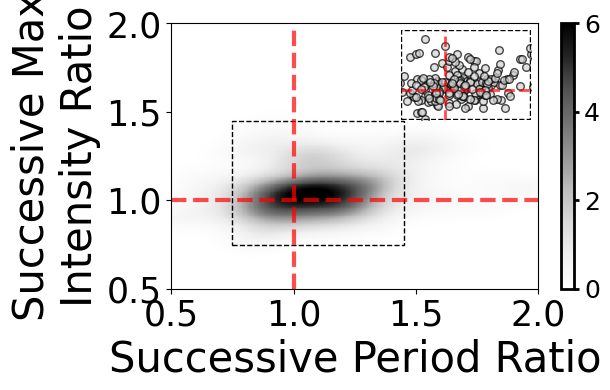

In [63]:
fig = plt.figure(figsize=[6.5, 4])
ax = fig.add_subplot(111)
# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location

mesh = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), 
               shading='auto', cmap='Greys', vmin=0, vmax=6)

axins = inset_axes(ax, width=1.3, height=0.9)

for i in range(n_cells):
    if label_ratio[i] == 'fgf':
        axins.scatter(period_ratio[i], amplitude_ratio[i], color='lightgrey', s=30, linewidth=1, edgecolor='black', alpha=0.7)
        count += 1
        
axins.axis('off')
axins.set_xlim([0.75, 1.5])
axins.set_ylim([0.75, 1.5])
        
# Colorbar
cb = plt.colorbar(mesh, ax=ax)
cb.outline.set_linewidth(2)
cb.set_ticks(np.arange(0,7,2))
cb.set_ticklabels(np.arange(0,7,2), fontsize=18)
cb.ax.tick_params(width=2)

x_rect = 0.75
y_rect = 0.75
width = 0.70
height = 0.70
ax.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

x_rect = 0.75
y_rect = 0.76
width = 0.745
height = 0.74
axins.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

# Axes
ax.axvline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)
ax.axhline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)

axins.axvline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)
axins.axhline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)

ax.set(xlim=(xy_min,xy_max), ylim=(xy_min,xy_max))
ax.set_xticks(np.arange(xy_min,xy_max+step, step))
ax.set_yticks(np.arange(xy_min,xy_max+step, step))
ax.set_xticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)
ax.set_yticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)

ax.set_xlabel('Successive Period Ratio', fontsize=30)
ax.set_ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()



fig.savefig('../Data/FGF/Results/SuccessivePeak-Intensity_PSM4FGF_psm4_vs_fgf.pdf', bbox_inches='tight')

## I$^{+}$ and I$^{-}$


For this, we will align all the peaks from the first (the first peak is peak number 1) since all cells have a last peak but we cannot tell for sure when do they started. This is the same procedure used for the other in vitro and in vivo cells for Figures 1 and 2. 

<a id='is'></a>
If you want to go to the top of the notebook click here: [Top](#top)

### PSM4 I+ vs I-

In [64]:
n_cells = len(intensities)
# Find maximum number of cycles
n_cycles = 0

for i in range(n_cells):
    if labels[i] == 'psm4':
        if len(i_minus[i]) > n_cycles:
            n_cycles = len(i_minus[i])
        
print(f'There are {n_cycles} maximum')

There are 6 maximum


In [65]:
# Arrange in terms of number of cycles
i_minus_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}
i_plus_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}

for i in range(len(i_plus)):
    if labels[i] == 'psm4':
        # We start from the last peak
        for j, val in enumerate(i_plus[i]):
            i_plus_cycle[j+1].append(val)
            
        for j, val in enumerate(i_minus[i]):
            i_minus_cycle[j+1].append(val)
    
# Convert into list arrays  
min_cycle = []
max_cycle = []

for i in range(n_cycles):
    min_cycle.append(np.array(i_minus_cycle[i+1]))
    max_cycle.append(np.array(i_plus_cycle[i+1]))

In [66]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

I+ diff mean:  24.8917748917749
% compared to previous cycle: [1.79968701 1.74242424 1.75773787 1.73323286 1.67883212]
I+ median values: [1383.1168831168832, 1428.5714285714287, 1416.125541125541, 1436.1471861471864, 1482.6839826839828] GSV
I- diff mean:  -0.7664949717930085
% compared to previous cycle: [-0.06334566 -0.0641585  -0.0636278  -0.06374949 -0.06350658]
I- median values: [1210.019622271278, 1194.6897228354183, 1204.654157468727, 1202.3546725533479, 1206.953642384106] GSV


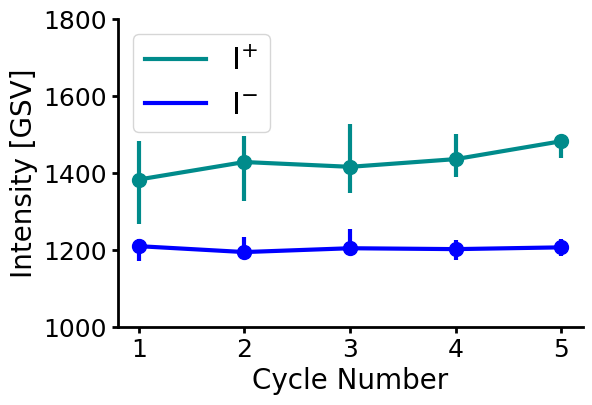

In [67]:
%matplotlib inline
# Plot
fig = plt.figure(figsize=[6,4])

# Maxima
max_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles-1):
    aux = max_cycle[i][~np.isnan(max_cycle[i])]
    max_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(max_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

# Plot ticks 
plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=16);
plt.yticks(fontsize=16)
plt.xlabel('Number of cycles', fontsize=18)
plt.ylabel('Intensity [GSV]', fontsize=18)
#plt.ylim([0,40])

inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='darkcyan', linewidth=3, label=r'I$^{+}$')
plt.scatter(inds, medians, marker='o', color='darkcyan', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='darkcyan', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=2)

print('I+ diff mean: ', np.mean(np.diff(medians)))
i_diff = np.mean(np.diff(medians))

print(f'% compared to previous cycle: {(i_diff*100)/medians}')

print('I+ median values:', medians, 'GSV')

# Minima
# Remove nans for violin plot
min_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles-1):
    aux = min_cycle[i][~np.isnan(min_cycle[i])]
    min_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(min_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )
plt.plot(inds, medians, color='blue', linewidth=3, label=r'I$^{-}$')
plt.scatter(inds, medians, marker='o', color='blue', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='blue', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=2)

print('I- diff mean: ', np.mean(np.diff(medians)))
i_diff = np.mean(np.diff(medians))

print(f'% compared to previous cycle: {(i_diff*100)/medians}')

print('I- median values:', medians, 'GSV')


plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);
plt.legend(loc='upper left', fontsize=22)
plt.yticks(fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.yticks(np.arange(1000, 2000,200))
plt.ylim([1000, 1800])
plt.xlim([-0.2, 4.2])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/FGF/Results/MaxMinIntensity-Bycycle-PSM4.pdf', format='pdf',bbox_inches='tight')

In [68]:
# T plus, T minus -  save for simulation
I_plus_psm4 = np.concatenate(max_cycle).tolist()
I_minus_psm4 = np.concatenate(min_cycle).tolist()

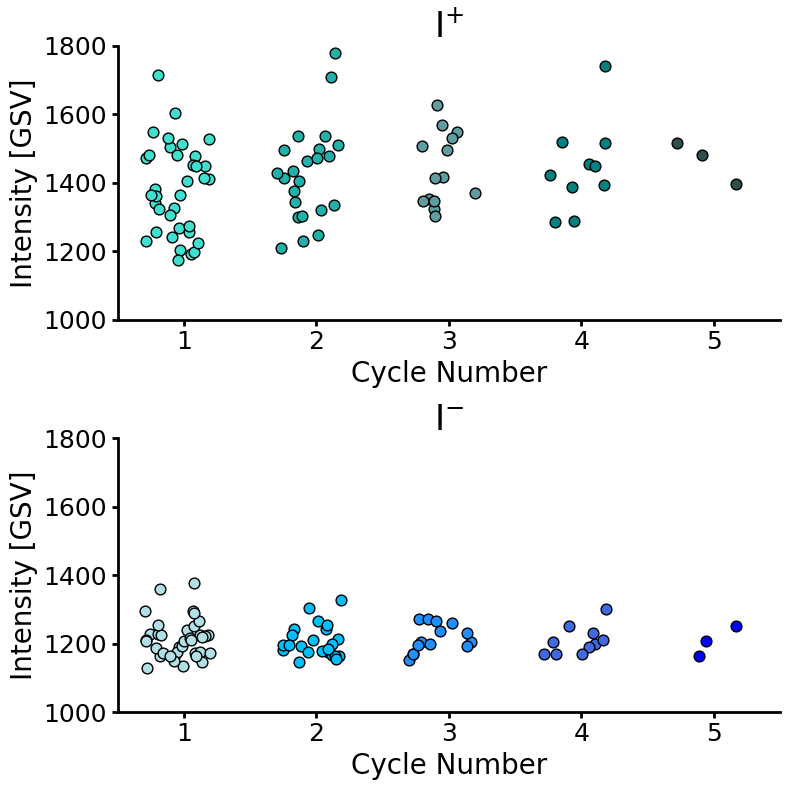

In [69]:
# I+
plt.figure(figsize=[8, 8])

plt.subplot(211)
colors = ['turquoise', 'lightseagreen', 'cadetblue', 'teal', 'darkslategrey']
for i in range(n_cycles-1):
    plt.scatter(np.random.random(len(max_cycle[i]))/2+i-0.3, max_cycle[i], c=colors[i], s=60,
               edgecolor='k')
    
plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);

plt.yticks(fontsize=18)
plt.title('I$^{+}$', fontsize=25)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.yticks(np.arange(1000, 2000,200))
plt.ylim([1000, 1800])
plt.xlim([-0.5, 4.5])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


# I-
plt.subplot(212)
colors = ['powderblue', 'deepskyblue', 'dodgerblue', 'royalblue', 'blue']
for i in range(n_cycles-1):
    plt.scatter(np.random.random(len(min_cycle[i]))/2+i-0.3, min_cycle[i], c=colors[i], s=60,
               edgecolor='k')
    
plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);

plt.yticks(fontsize=18)
plt.title('I$^{-}$', fontsize=25)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.yticks(np.arange(1000, 2000,200))
plt.ylim([1000, 1800])
plt.xlim([-0.5, 4.5])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

### PSM4 + FGF  I+ vs I-

In [70]:
n_cells = len(intensities)
# Find maximum number of cycles
n_cycles = 0

for i in range(n_cells):
    if labels[i] == 'fgf':
        if len(a_minus[i]) > n_cycles:
            n_cycles = len(i_minus[i])
        
print(f'There are {n_cycles} maximum')

There are 11 maximum


In [71]:
# Arrange in terms of number of cycles
i_minus_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}
i_plus_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}

for i in range(len(i_plus)):
    if labels[i] == 'fgf':
        # We start from the last peak
        for j, val in enumerate(i_plus[i]):
            i_plus_cycle[j+1].append(val)
            
        for j, val in enumerate(i_minus[i]):
            i_minus_cycle[j+1].append(val)
    
# Convert into list arrays  
min_cycle = []
max_cycle = []

for i in range(n_cycles):
    min_cycle.append(np.array(i_minus_cycle[i+1]))
    max_cycle.append(np.array(i_plus_cycle[i+1]))

I+ diff mean:  15.286796536796544
% compared to previous cycle: [1.15683866 1.09836703 1.04552184 1.05096726 1.00892857 0.98022207
 0.97886348 1.00319602 1.05884558]
I+ median values: [1321.4285714285716, 1391.7748917748918, 1462.121212121212, 1454.5454545454545, 1515.1515151515152, 1559.5238095238096, 1561.6883116883118, 1523.8095238095239, 1443.722943722944] GSV
I- diff mean:  -1.0539305862153583
% compared to previous cycle: [-0.0871555  -0.08622636 -0.08617232 -0.08601061 -0.08633464 -0.08655202
 -0.08479071 -0.08579594 -0.08776745]
I- median values: [1209.253127299485, 1222.2835418199656, 1223.0500367917587, 1225.3495217071377, 1220.7505518763796, 1217.6845719892076, 1242.9789060583762, 1228.4155015943095, 1200.821682609762] GSV


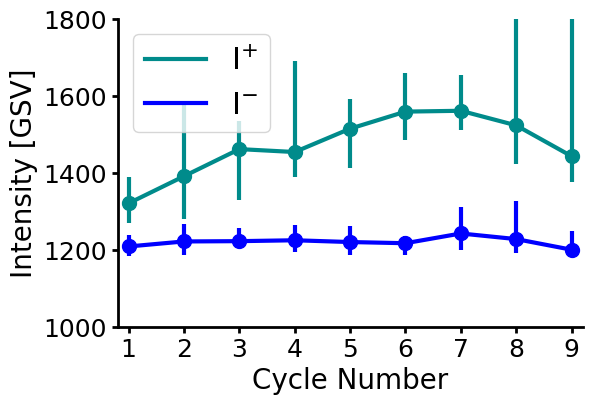

In [72]:
# Plot
fig = plt.figure(figsize=[6,4])

# Maxima
max_nan = []
quartile1 = []
quartile3 = []
medians = []

n = 2
for i in range(n_cycles-n):
    aux = max_cycle[i][~np.isnan(max_cycle[i])]
    max_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(max_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

# Plot ticks 
plt.xticks(np.arange(0,n_cycles-n,1), np.arange(1,n_cycles-n+1,1), fontsize=16);
plt.yticks(fontsize=16)
plt.xlabel('Number of cycles', fontsize=18)
plt.ylabel('Intensity [GSV]', fontsize=18)
#plt.ylim([0,40])

inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='darkcyan', linewidth=3, label=r'I$^{+}$')
plt.scatter(inds, medians, marker='o', color='darkcyan', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='darkcyan', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=2)

print('I+ diff mean: ', np.mean(np.diff(medians)))
i_diff = np.mean(np.diff(medians))

print(f'% compared to previous cycle: {(i_diff*100)/medians}')

print('I+ median values:', medians, 'GSV')

# Minima
# Remove nans for violin plot
min_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles-n):
    aux = min_cycle[i][~np.isnan(min_cycle[i])]
    min_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(min_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )
plt.plot(inds, medians, color='blue', linewidth=3, label=r'I$^{-}$')
plt.scatter(inds, medians, marker='o', color='blue', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='blue', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=2)

print('I- diff mean: ', np.mean(np.diff(medians)))
i_diff = np.mean(np.diff(medians))

print(f'% compared to previous cycle: {(i_diff*100)/medians}')

print('I- median values:', medians, 'GSV')

plt.xticks(np.arange(0,n_cycles-n,1), np.arange(1,n_cycles-n+1,1), fontsize=18);
plt.legend(loc='upper left', fontsize=22)
plt.yticks(fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.yticks(np.arange(1000, 2000,200))
plt.ylim([1000, 1800])
plt.xlim([-0.2, 8.2])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/FGF/Results/MaxMinIntensity-Bycycle-FGF.pdf', format='pdf',bbox_inches='tight')

In [73]:
# T plus, T minus -  save for simulation
I_plus_fgf = np.concatenate(max_cycle).tolist()
I_minus_fgf = np.concatenate(min_cycle).tolist()

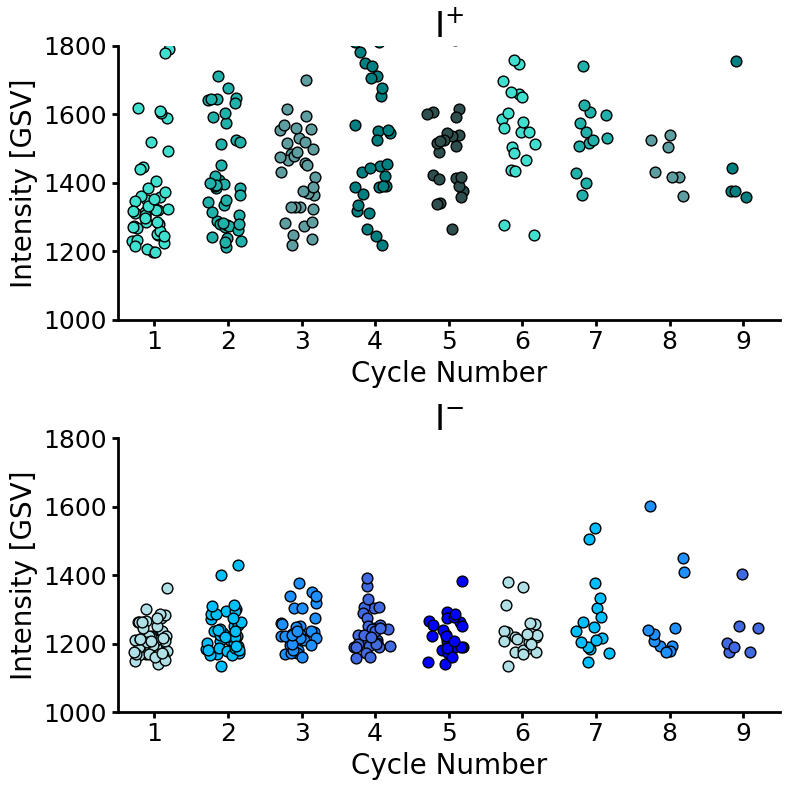

In [74]:
# I+
plt.figure(figsize=[8, 8])

plt.subplot(211)
colors = ['turquoise', 'lightseagreen', 'cadetblue', 'teal', 'darkslategrey']*2
for i in range(n_cycles-n):
    plt.scatter(np.random.random(len(max_cycle[i]))/2+i-0.3, max_cycle[i], c=colors[i], s=60,
               edgecolor='k')
    
plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);

plt.yticks(fontsize=18)
plt.title('I$^{+}$', fontsize=25)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.yticks(np.arange(1000, 2000,200))
plt.ylim([1000, 1800])
plt.xlim([-0.5, 8.5])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


# I-
plt.subplot(212)
colors = ['powderblue', 'deepskyblue', 'dodgerblue', 'royalblue', 'blue']*2
for i in range(n_cycles-n):
    plt.scatter(np.random.random(len(min_cycle[i]))/2+i-0.3, min_cycle[i], c=colors[i], s=60,
               edgecolor='k')
    
plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);

plt.yticks(fontsize=18)
plt.title('I$^{-}$', fontsize=25)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.yticks(np.arange(1000, 2000,200))
plt.ylim([1000, 1800])
plt.xlim([-0.5, 8.5])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

## Period

<a id='period'></a>
If you want to go to the top of the notebook click here: [Top](#top)

In [76]:
n_cells = len(intensities)
# Find maximum number of cycles
n_cycles = 0

for i in range(n_cells):
    if labels[i] == 'psm4':
        if len(a_minus[i]) > n_cycles:
            n_cycles = len(a_minus[i])
        
print(f'There are {n_cycles} maximum')

There are 6 maximum


In [77]:
# Arrange in terms of number of cycles
periods_by_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}

for i in range(len(periods)):
    if labels[i] == 'psm4':
        for j, val in enumerate(periods[i]):
            periods_by_cycle[j+1].append(val)
    
# Convert into list arrays  
period_cycle = []

for i in range(n_cycles):
    period_cycle.append(np.array(periods_by_cycle[i+1]))

T diff mean:  7.2209677419354605
% compared to previous cycle: [12.01298701 11.70886076 10.27777778 10.27777778  8.11403509]
T median values: [60.109677419354824, 61.6709677419355, 70.25806451612905, 70.25806451612905, 88.99354838709667] min


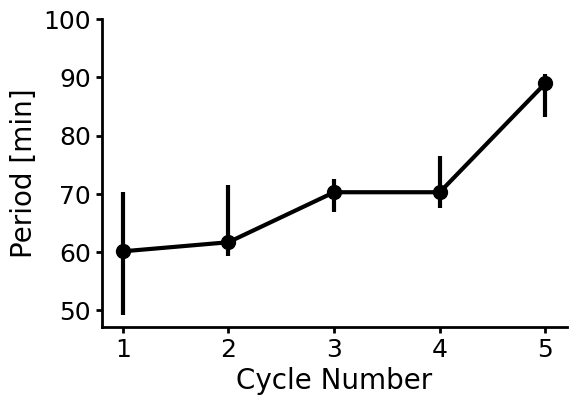

In [78]:
# Plot

fig = plt.figure(figsize=[6,4])


# Maxima
period_nan = []
quartile1 = []
quartile3 = []
medians = []
period_cycle_aux = period_cycle.copy()

for i in range(n_cycles-1):
    aux = period_cycle_aux[i][~np.isnan(period_cycle_aux[i])]
    period_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(period_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]



inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='black', linewidth=3, label='Max Amp')
plt.scatter(inds, medians, marker='o', color='black', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='red', linestyle='-', lw=3)

print('T diff mean: ', np.mean(np.diff(medians)))
t_diff = np.mean(np.diff(medians))

print(f'% compared to previous cycle: {(t_diff*100)/medians}')

print('T median values:', medians, 'min')

plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);
plt.yticks(np.arange(50,110,10), fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Period [min]', fontsize=20)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()

fig.savefig('../Data/FGF/Results/Periods-Bycycle-PSM4.pdf', format='pdf', bbox_inches='tight')

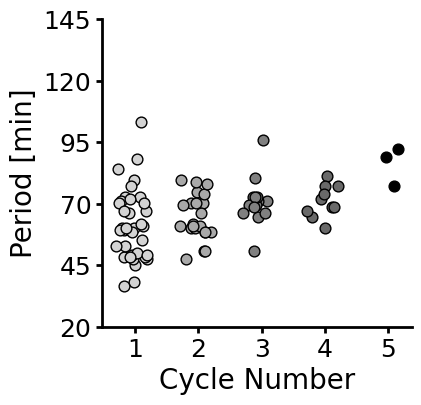

In [79]:
# I+
plt.figure(figsize=[4, 4])

colors = ['lightgrey', 'darkgrey', 'grey', 'dimgrey','black']
for i in range(n_cycles-1):
    plt.scatter(np.random.random(len(period_cycle[i]))/2+i-0.3, period_cycle[i], c=colors[i], s=60,
               edgecolor='k')
    


plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);
plt.yticks(np.arange(20,170,25), fontsize=18)
plt.ylim([20,145])

plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Period [min]', fontsize=20)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

### FGF

In [80]:
n_cells = len(intensities)
# Find maximum number of cycles
n_cycles = 0

for i in range(n_cells):
    if labels[i] == 'fgf':
        if len(a_minus[i]) > n_cycles:
            n_cycles = len(a_minus[i])
        
print(f'There are {n_cycles} maximum')

There are 11 maximum


In [81]:
# Arrange in terms of number of cycles
periods_by_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}

for i in range(len(periods)):
    if labels[i] == 'fgf':
        for j, val in enumerate(periods[i]):
            periods_by_cycle[j+1].append(val)
    
# Convert into list arrays  
period_cycle = []

for i in range(n_cycles):
    period_cycle.append(np.array(periods_by_cycle[i+1]))

T diff mean:  3.903225806451621
% compared to previous cycle: [6.57894737 6.02409639 5.74712644 5.74712644 5.         5.05050505
 5.34759358 4.34782609 4.31034483]
T median values: [59.329032258064515, 64.79354838709679, 67.91612903225808, 67.91612903225811, 78.0645161290322, 77.2838709677419, 72.99032258064511, 89.77419354838707, 90.55483870967748] min


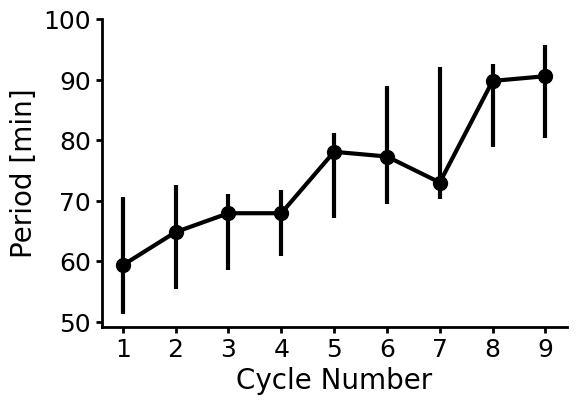

In [82]:
# Plot

fig = plt.figure(figsize=[6,4])


# Maxima
period_nan = []
quartile1 = []
quartile3 = []
medians = []
period_cycle_aux = period_cycle.copy()
n = 2
for i in range(n_cycles-n):
    aux = period_cycle_aux[i][~np.isnan(period_cycle_aux[i])]
    period_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(period_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]



inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='black', linewidth=3, label='Max Amp')
plt.scatter(inds, medians, marker='o', color='black', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='red', linestyle='-', lw=3)

print('T diff mean: ', np.mean(np.diff(medians)))
t_diff = np.mean(np.diff(medians))

print(f'% compared to previous cycle: {(t_diff*100)/medians}')

print('T median values:', medians, 'min')

plt.xticks(np.arange(0,n_cycles-n,1), np.arange(1,n_cycles-n+1,1), fontsize=18);
plt.yticks(np.arange(50,110,10), fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Period [min]', fontsize=20)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()

fig.savefig('../Data/FGF/Results/Periods-Bycycle-FGF.pdf', format='pdf', bbox_inches='tight')

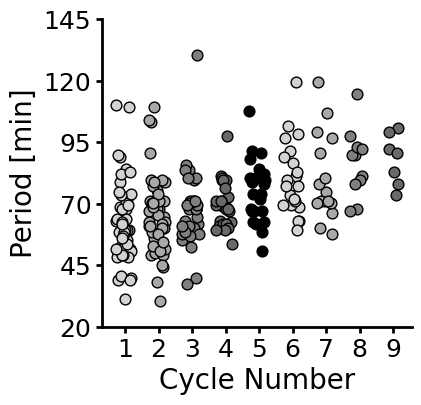

In [83]:
# I+
plt.figure(figsize=[4, 4])

colors = ['lightgrey', 'darkgrey', 'grey', 'dimgrey','black']*2
for i in range(n_cycles-n):
    plt.scatter(np.random.random(len(period_cycle[i]))/2+i-0.3, period_cycle[i], c=colors[i], s=60,
               edgecolor='k')
    
plt.xticks(np.arange(0,n_cycles-n,1), np.arange(1,n_cycles-n+1,1), fontsize=18);


plt.yticks(np.arange(20,170,25), fontsize=18)
plt.ylim([20,145])
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Period [min]', fontsize=20)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()